In [9]:
import numpy as np
a = [np.random.random(1) for x in xrange(1,100)]
print a

[array([ 0.16194242]), array([ 0.93306784]), array([ 0.83834843]), array([ 0.76205787]), array([ 0.53765136]), array([ 0.90304832]), array([ 0.82803325]), array([ 0.95177407]), array([ 0.07533559]), array([ 0.18240558]), array([ 0.461183]), array([ 0.24224318]), array([ 0.48533819]), array([ 0.35214622]), array([ 0.49558412]), array([ 0.35934685]), array([ 0.73314414]), array([ 0.56012921]), array([ 0.19393036]), array([ 0.544517]), array([ 0.48860863]), array([ 0.80693499]), array([ 0.23465717]), array([ 0.56676561]), array([ 0.55125929]), array([ 0.60500645]), array([ 0.05888761]), array([ 0.89498836]), array([ 0.82773714]), array([ 0.06695487]), array([ 0.76838545]), array([ 0.82553184]), array([ 0.63738802]), array([ 0.94663017]), array([ 0.29257486]), array([ 0.81614696]), array([ 0.94183933]), array([ 0.19513405]), array([ 0.05278626]), array([ 0.01738597]), array([ 0.44115182]), array([ 0.1585237]), array([ 0.21817593]), array([ 0.08469288]), array([ 0.19997425]), array([ 0.8009

### Using the simple neural network from neuralnetworksanddeeplearning.com

"""
network.py
~~~~~~~~~~

A module to implement the stochastic gradient descent learning
algorithm for a feedforward neural network.  Gradients are calculated
using backpropagation.  Note that I have focused on making the code
simple, easily readable, and easily modifiable.  It is not optimized,
and omits many desirable features.
"""

#### Libraries
# Standard library
import random

# Third-party libraries
import numpy as np

class Network(object):

    def __init__(self, sizes):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            test_data=None):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""
        if test_data: n_test = len(test_data)
        n = len(training_data)
        for j in xrange(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in xrange(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                print "Epoch {0}: {1} / {2}".format(
                    j, self.evaluate(test_data), n_test)
            else:
                print "Epoch {0} complete".format(j)

    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in xrange(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (output_activations-y)

#### Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))



### This function minimizes with custom function

In [10]:
from test_suite import custom_minimize
from scipy.optimize import basinhopping as hop

custom_minimize(lambda x: x**2, hop, [10.])


basinhopping took 0.0421710014343 seconds. The result, 1.12241264832e-17 was found at ([  3.35024275e-09])
basinhopping used 94.50390625 megabytes and took 100 iterations



In [7]:
from pybrain.optimization import GA
result = GA(lambda x:sum(x**2),[10.,],minimize=True)
result.learn()


(array([  5.48233743e-06]), 3.0056023738701803e-11)

### These black-box optimization methods require a list-wise operation, even on functions from R->R
### It looks like GA does not have an attribute of number of generations... (from looking at their source code), so I will use all of these features in a specific way to call its attributes

In [9]:
# Our workaround for GA
def GA_minimize(function, guess):
    
    from pybrain.optimization import GA
    import timeit
    from memory_profiler import memory_usage
    
    result = GA(function,[guess, ], minimize=True)
    
    start = timeit.default_timer()
    mem = max(memory_usage((result.learn,(),)))
    stop = timeit.default_timer()
    
    print result.learn() #Comment this out for faster performance, i.e. for evaluation

    exec_time = stop-start

    print '{0} took {1} seconds'.format('Genetic Algorithm',exec_time)
    print '{0} used {1} megabytes'.format('Genetic Algorithm',mem)
    print

GA_minimize(lambda x:sum(x**2),10.)


(array([  4.76505381e-06]), 2.2705737827188729e-11)
Genetic Algorithm took 22.5820951462 seconds
Genetic Algorithm used 94.48828125 megabytes



### Bar Graph Template http://matplotlib.org/examples/api/barchart_demo.html 

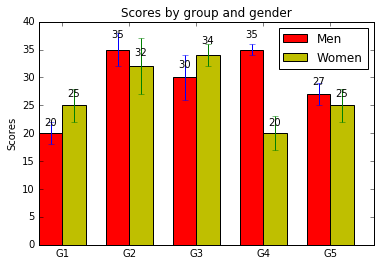

In [15]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

N = 5
menMeans = (20, 35, 30, 35, 27)
menStd = (2, 3, 4, 1, 2)

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, menMeans, width, color='r', yerr=menStd)

womenMeans = (25, 32, 34, 20, 25)
womenStd = (3, 5, 2, 3, 3) # the confidence interval or the std deviation
rects2 = ax.bar(ind + width, womenMeans, width, color='y', yerr=womenStd)

# add some text for labels, title and axes ticks
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(ind + width)
ax.set_xticklabels(('G1', 'G2', 'G3', 'G4', 'G5'))

ax.legend((rects1[0], rects2[0]), ('Men', 'Women'))


def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

# Results from root means squared error objective function

Nelder-Mead took 73.8156878948 seconds. The result, 397.946431233 was found at (-97.2243219614, 1.62465067804) Nelder-Mead used 87.56640625 megabytes and took 69.0 iterations

Powell took 102.296751022 seconds. The result, nan was found at (-27.4739053532, 0.274894413458) Powell used 87.5703125 megabytes and took 28.0 iterations

CG took 967.848807096 seconds. The result, 397.946431246 was found at (-97.226373943, 1.35675756514) CG used 87.5703125 megabytes and took 52.0 iterations

BFGS took 32.2478640079 seconds. The result, nan was found at (-315655.4971, -44984.1665113) BFGS used 87.6328125 megabytes and took 3.0 iterations

L-BFGS-B took 30.2151210308 seconds. The result, 397.946431622 was found at (-97.2352796645, 57.1105312168) L-BFGS-B used 87.7578125 megabytes and took 6.0 iterations

TNC took 12.0557310581 seconds. The result, 421.937094344 was found at (-500.0, 1.0) TNC used 87.92578125 megabytes and took 0.0 iterations

COBYLA took 474.013291836 seconds. The result, 412.637188539 was found at (-272.261846785, 2.36548167553) COBYLA used 87.9296875 megabytes and took -1.0 iterations

SLSQP took 36.7581448555 seconds. The result, 397.946431938 was found at (-97.2095787659, 58.2472771029) SLSQP used 87.93359375 megabytes and took 17.0 iterations

----------------------------------------------------------------------------------------------------------

Basinhopping took 1963.73302293 seconds. The result, 397.946431233 was found at (-97.2243260013, 11.9417785317) Basinhopping used 102.2734375 megabytes and took 100.0 iterations (Same result as local minimization)

### Computing the error for all of these methods

In [14]:
data = [397.946431233, None, 397.946431246, None, 397.946431622, 421.937094344, 412.637188539, 397.946431938, 397.946431233]
correct_answer = 397.946431233 # using the basinhopping answer as the reference point (assuming that it's the most correct)

error = []

for point in data:
    
    if point is None:
        error.append(None)
    
    else:
        error.append(correct_answer-point)
    
print error


[0.0, None, -1.2999976206629071e-08, None, -3.8899997889529914e-07, -23.990663111000003, -14.690757306000023, -7.049999908304017e-07, 0.0]


### Method vs Error

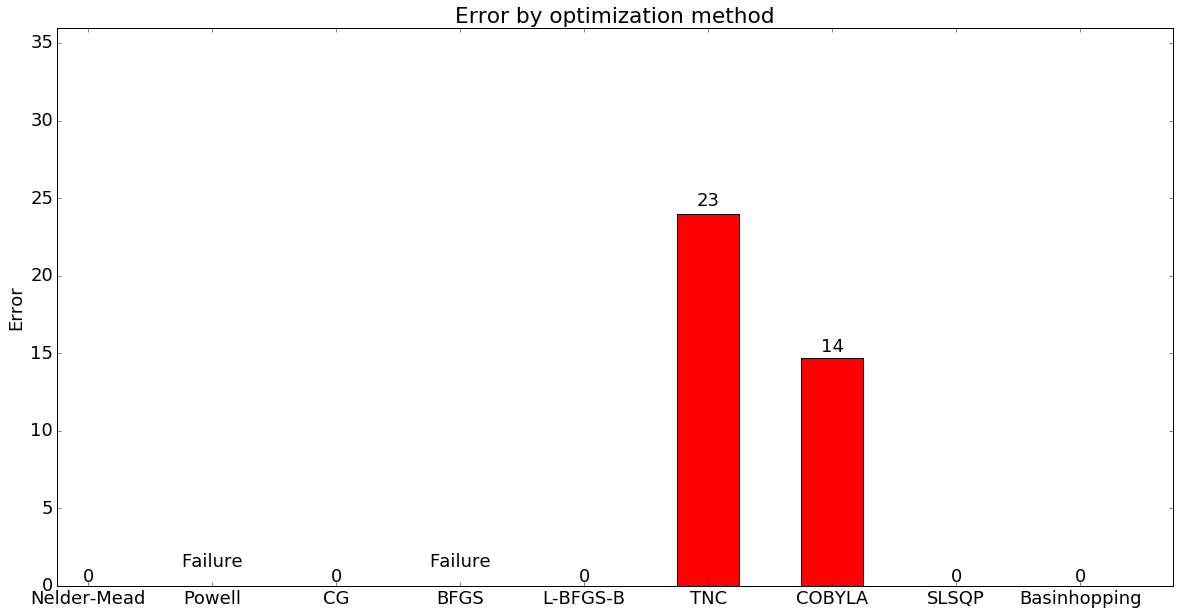

In [40]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

#returns the error of each optimization method
def _getError():
    
    # experimentally determined data
    data = [397.946431233, None, 397.946431246, None, 397.946431622, 421.937094344, 412.637188539, 397.946431938, 397.946431233]
    correct_answer = 397.946431233 # using the basinhopping answer as the reference point (assuming that it's the most correct)

    error = []

    for point in data:

        if point is None:
            error.append(-1) # indicates the failure to converge

        else:
            error.append(abs(correct_answer-point))
            
    return error

error = _getError()
N = len(error) # Number of error minimization methods tested

ind = np.arange(N)  # the x locations for the groups
width = 0.50       # the width of the bars

matplotlib.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(figsize=(20,10))
rects1 = ax.bar(ind, error, width, color='r')

# add some text for labels, title and axes ticks
ax.set_ylabel('Error')
ax.set_title('Error by optimization method')
ax.set_xticks(ind + width/2.)
ax.set_xticklabels(('Nelder-Mead', 'Powell', 'CG', 'BFGS', 'L-BFGS-B', 'TNC', 'COBYLA', 'SLSQP', 'Basinhopping'))

# puts graph labels above bars
def autolabel(rects):
    # attach some text labels
    for index, rect in enumerate(rects):
        height = rect.get_height()
        
        if error[index] is -1:
            ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                'Failure',
                ha='center', va='bottom')
        else:    
            ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
plt.ylim(0,max(error)*1.5) # enforces limits on axis range
plt.show()

### Method vs Time to Termination

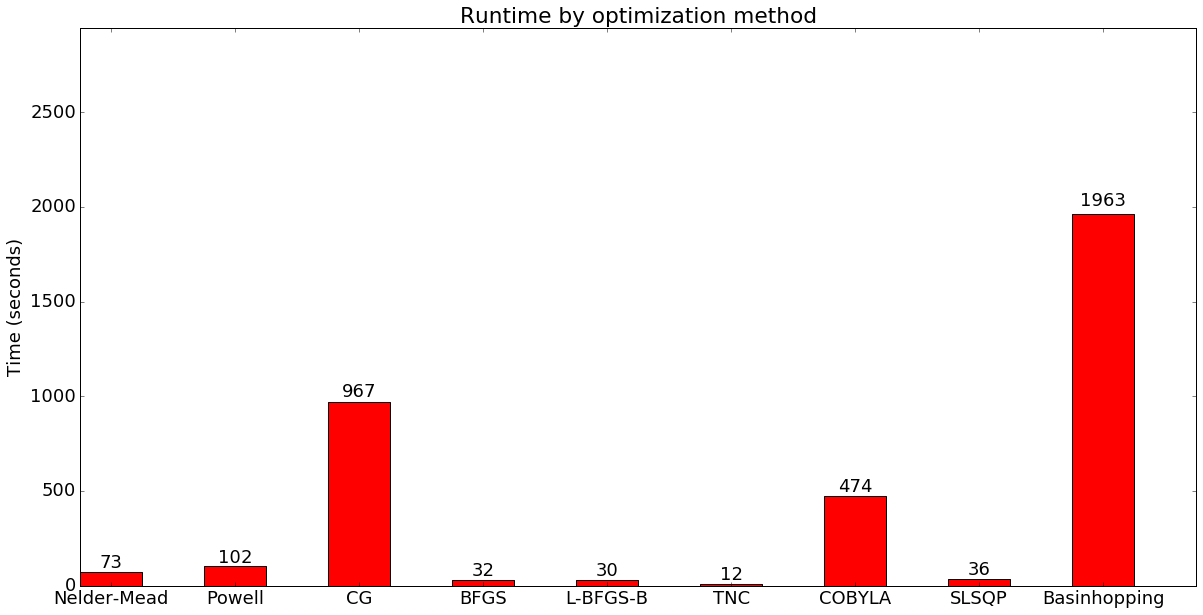

In [41]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

time = [73.8156878948, 102.296751022, 967.848807096, 32.2478640079, 30.2151210308, 12.0557310581, 474.013291836, 36.7581448555, 1963.73302293]
N = len(time) # Number of error minimization methods tested

ind = np.arange(N)  # the x locations for the groups
width = 0.50       # the width of the bars

matplotlib.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(figsize=(20,10))
rects1 = ax.bar(ind, time, width, color='r')

# add some text for labels, title and axes ticks
ax.set_ylabel('Time (seconds)')
ax.set_title('Runtime by optimization method')
ax.set_xticks(ind + width/2.)
ax.set_xticklabels(('Nelder-Mead', 'Powell', 'CG', 'BFGS', 'L-BFGS-B', 'TNC', 'COBYLA', 'SLSQP', 'Basinhopping'))

# puts graph labels above bars
def autolabel(rects):
    # attach some text labels
    for rect in rects:
        
        height = rect.get_height()
        
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
            '%d' % int(height),
            ha='center', va='bottom')

autolabel(rects1)
plt.ylim(0,max(time)*1.5) # enforces limits on axis range
plt.show()

### Memory consumption by optimization method (Revised)

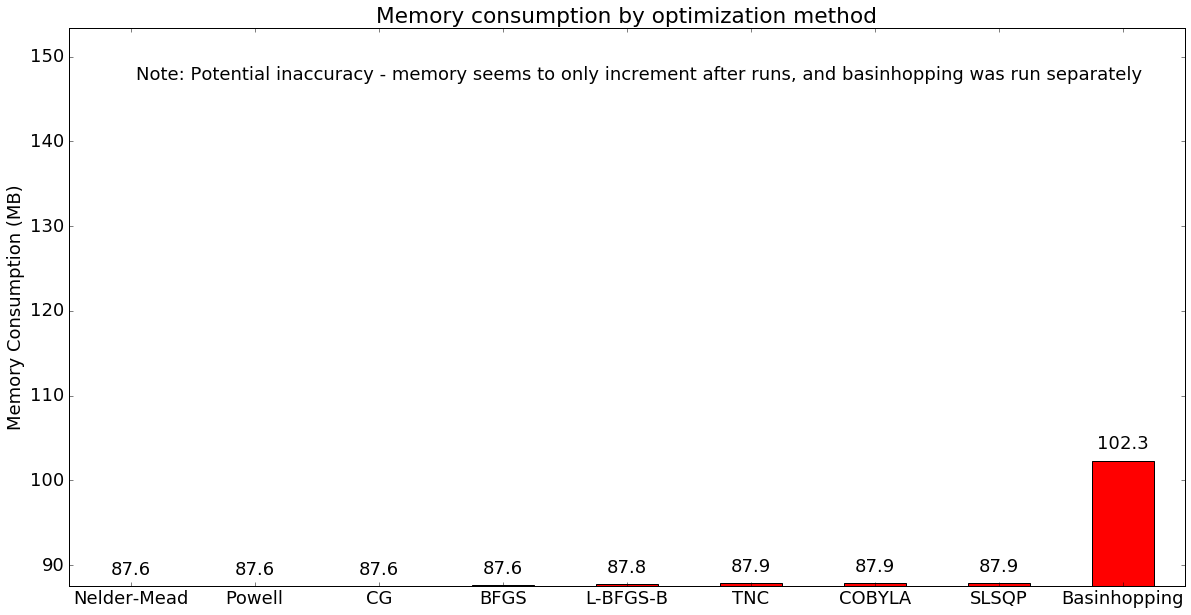

In [4]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

memory_consumption = [87.56640625, 87.5703125, 87.5703125, 87.6328125, 87.7578125, 87.92578125, 87.9296875, 87.93359375, 102.2734375]
N = len(memory_consumption) # Number of error minimization methods tested

width = 0.50       # the width of the bars
offset = width/2.
ind = np.arange(N)+offset

matplotlib.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(figsize=(20,10))
rects1 = ax.bar(ind, memory_consumption, width, color='r')

# add some text for labels, title and axes ticks
ax.set_ylabel('Memory Consumption (MB)')
ax.set_title('Memory consumption by optimization method')
ax.set_xticks(ind + offset)
ax.set_xticklabels(('Nelder-Mead', 'Powell', 'CG', 'BFGS', 'L-BFGS-B', 'TNC', 'COBYLA', 'SLSQP', 'Basinhopping'))

# puts graph labels above bars
def autolabel(rects):
    
    # attach some text labels
    for rect in rects:
        
        height = rect.get_height()
        
        ax.text(rect.get_x() + offset, 1.01*height,
            '%.1f' % height,
            ha='center', va='bottom')

plt.text(0.06, 0.9,'Note: Potential inaccuracy - memory seems to only increment after runs, and basinhopping was run separately',
horizontalalignment='left',
verticalalignment='bottom',
transform = ax.transAxes)

autolabel(rects1)
plt.ylim(min(memory_consumption),max(memory_consumption)*1.5) # enforces limits on axis range
plt.show()

### Number of algorithmic iterations by optimization method

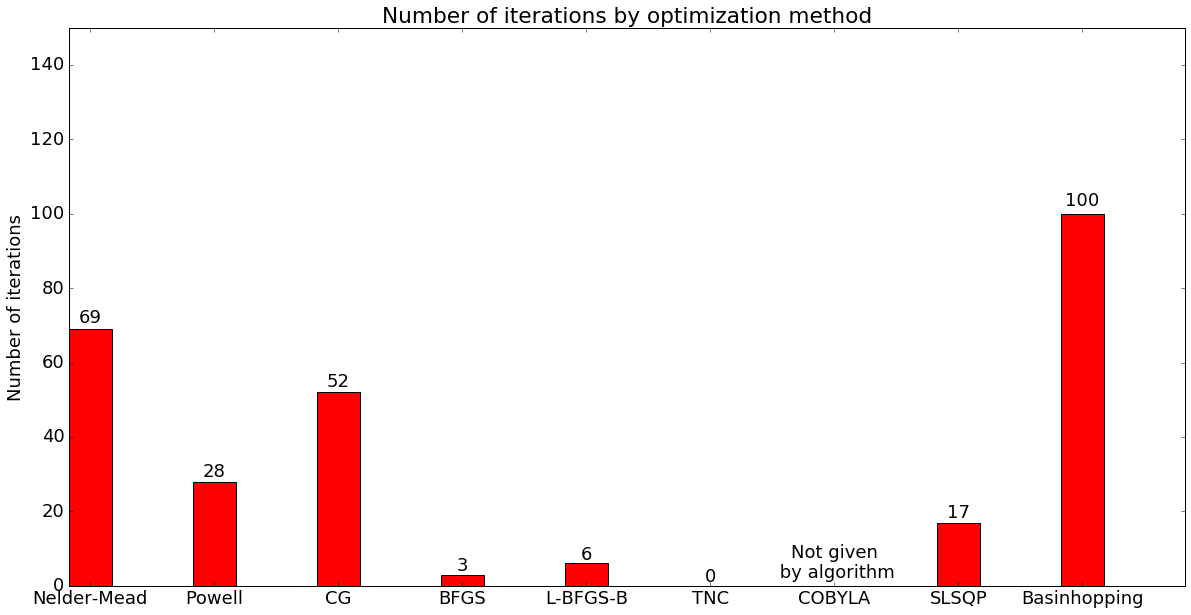

In [7]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

iterations = [69.0, 28.0, 52.0, 3.0, 6.0, 0.0, -1.0, 17.0, 100.0]
N = len(iterations) # Number of error minimization methods tested
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

matplotlib.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(figsize=(20,10))
rects1 = ax.bar(ind, iterations, width, color='r')

# add some text for labels, title and axes ticks
ax.set_ylabel('Number of iterations')
ax.set_title('Number of iterations by optimization method')
ax.set_xticks(ind + width/2.)
ax.set_xticklabels(('Nelder-Mead', 'Powell', 'CG', 'BFGS', 'L-BFGS-B', 'TNC', 'COBYLA', 'SLSQP', 'Basinhopping'))

# puts graph labels above bars
def autolabel(rects):
    # attach some text labels
    for index, rect in enumerate(rects):
        
        height = rect.get_height()
        
        if iterations[index] == -1.0:
            ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                'Not given\n by algorithm',
                ha='center', va='bottom')
        else:    
            ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
plt.ylim(0,max(iterations)*1.5) # enforces limits on axis range
plt.show()

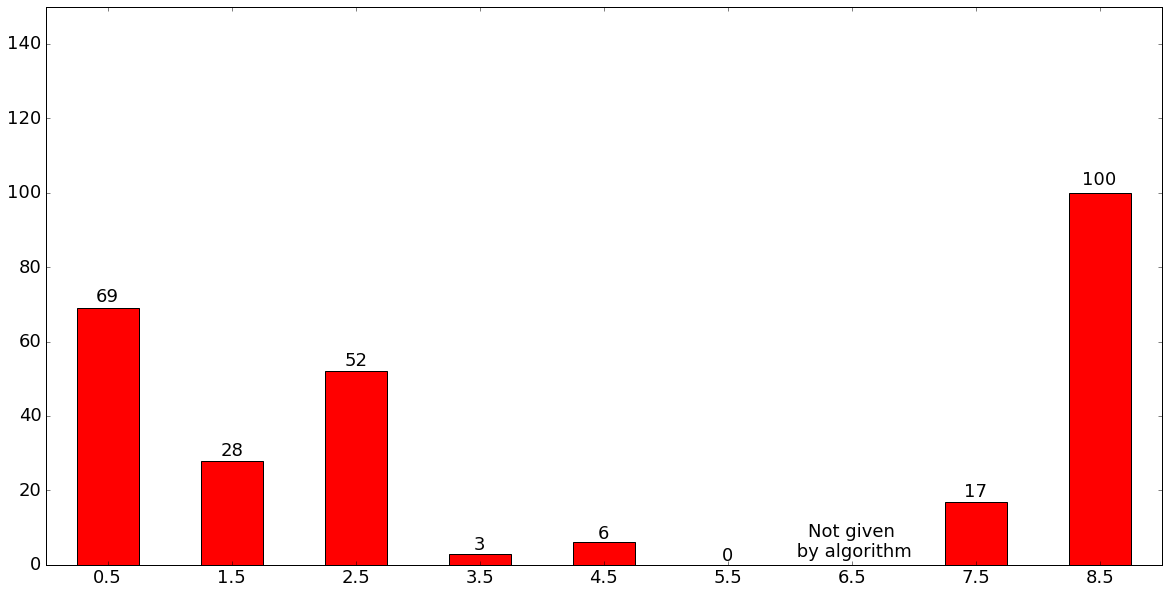

In [1]:
%matplotlib inline

from test_suite import barGraph
barGraph([69.0, 28.0, 52.0, 3.0, 6.0, 0.0, -1.0, 17.0, 100.0])

In [8]:
#-Testing closure

def hello():
    def inside():
        return "I am an inner function!"
    
    print "Hi!"
    
print inside() # inside is only accessible inside of the other function (first-class)

NameError: name 'inside' is not defined

In [11]:
def hello():
    def inside():
        return "I am an inner function!"
    
    return inside

print hello()() # call the call and you get the inner function here
    

I am an inner function!


# Revising output for readability

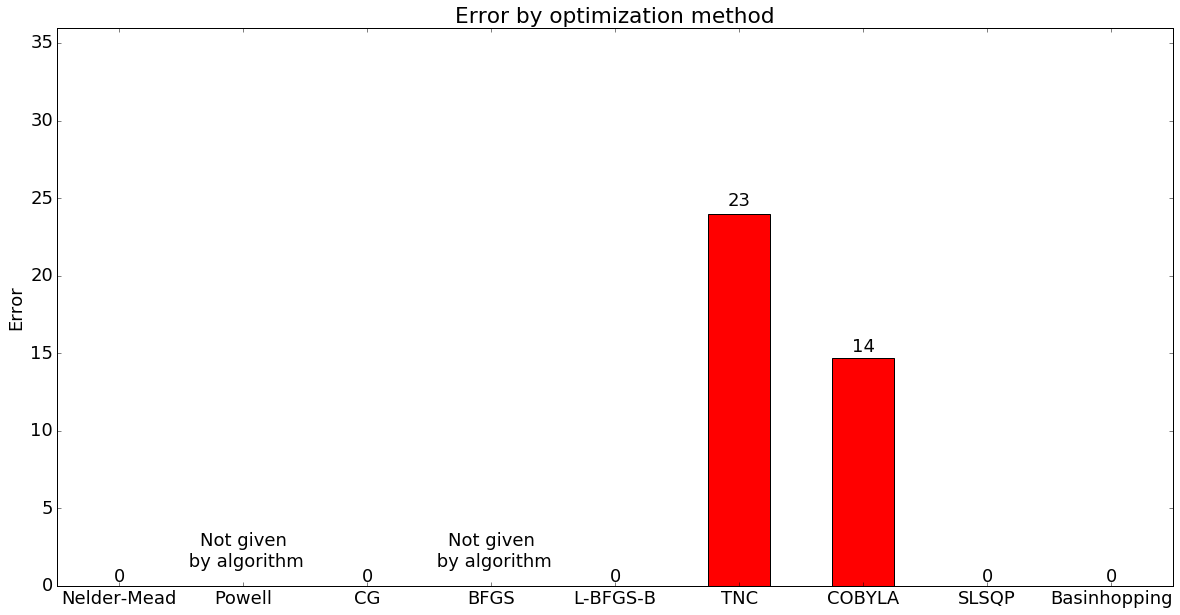

In [2]:
#returns the error of each optimization method
def _getError():
    
    # experimentally determined data
    data = [397.946431233, None, 397.946431246, None, 397.946431622, 421.937094344, 
            412.637188539, 397.946431938, 397.946431233]
    correct_answer = 397.946431233 
    # using the basinhopping answer as the reference point (assuming that it's the most correct)

    error = []

    for point in data:

        if point is None:
            error.append(-1) # indicates the failure to converge

        else:
            error.append(abs(correct_answer-point))
            
    return error

error = _getError()
barGraph(data=error,ylabel='Error',title='Error by optimization method',xticklabels=('Nelder-Mead', 'Powell', 
                                                                                     'CG', 'BFGS', 'L-BFGS-B', 'TNC', 
                                                                                     'COBYLA', 'SLSQP', 'Basinhopping'))



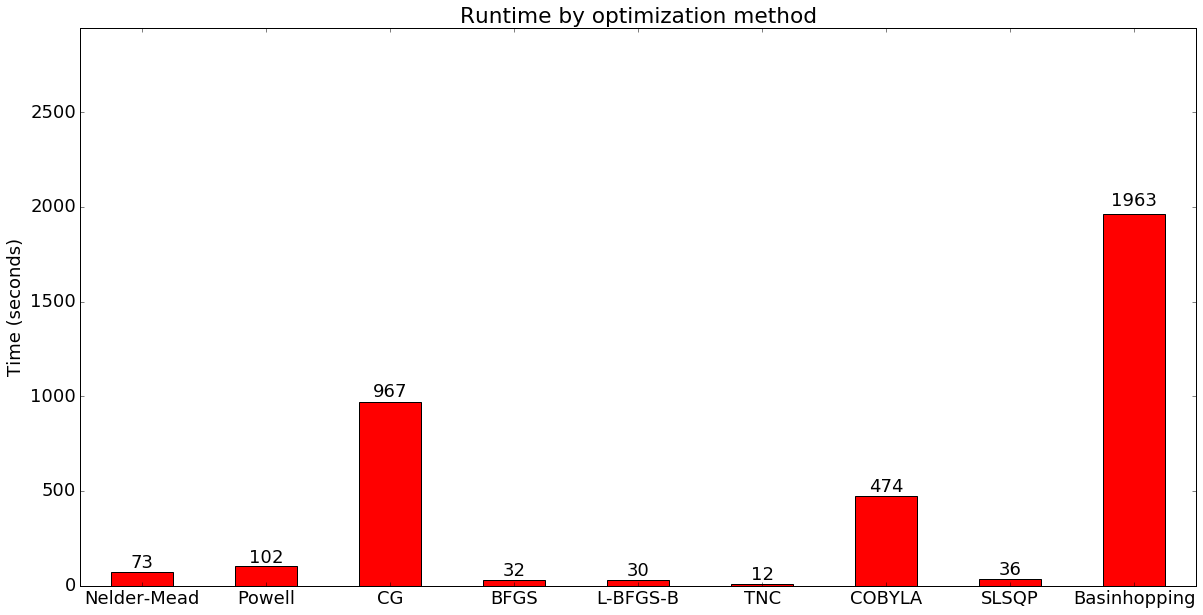

In [3]:
data = [73.8156878948, 102.296751022, 967.848807096, 
        32.2478640079, 30.2151210308, 12.0557310581, 474.013291836, 36.7581448555, 1963.73302293]


barGraph(data,ylabel='Time (seconds)',title='Runtime by optimization method', xticklabels=('Nelder-Mead', 'Powell', 'CG', 'BFGS'
                                                                                           , 'L-BFGS-B', 'TNC', 
                                                                                           'COBYLA', 'SLSQP', 'Basinhopping'))


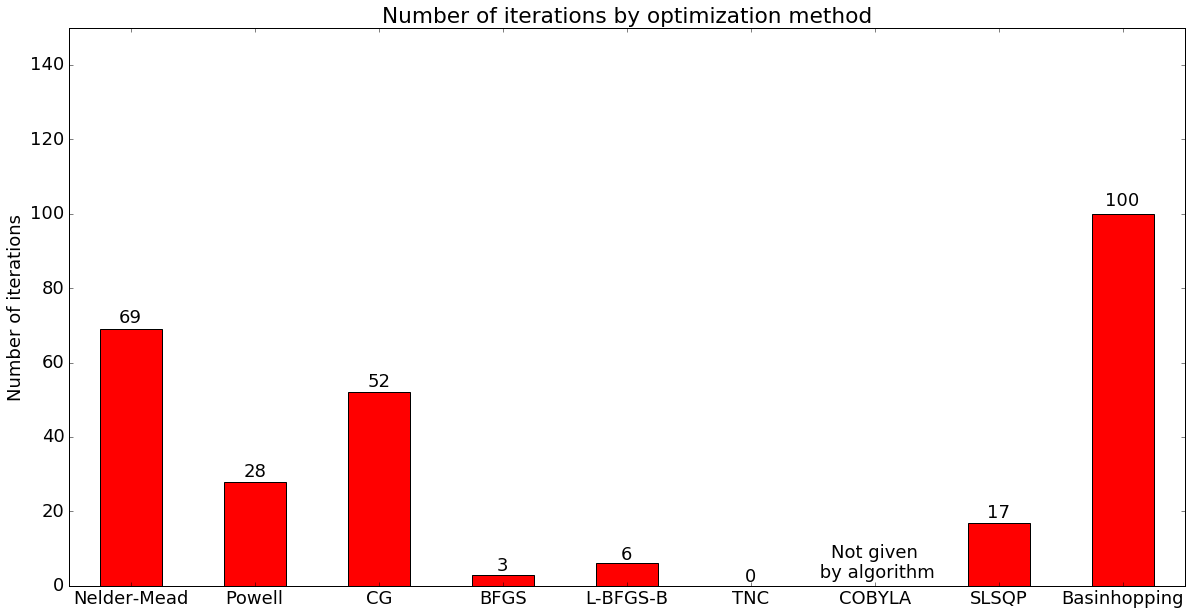

In [6]:
data = [69.0, 28.0, 52.0, 3.0, 6.0, 0.0, -1.0, 17.0, 100.0]
barGraph(data, ylabel='Number of iterations',title='Number of iterations by optimization method',
         xticklabels=('Nelder-Mead', 'Powell', 'CG', 'BFGS', 'L-BFGS-B', 'TNC', 'COBYLA', 'SLSQP', 'Basinhopping'))
